In [1]:
import sys
import scvi
import scgen
import rpy2
import scib
import json
import anndata
import logging
import warnings
import scanorama
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import scrublet as scr
import doubletdetection
from sklearn import cluster
from anndata import AnnData
from gtfparse import read_gtf
from os import PathLike, fspath
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` name

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
# #Note: this can be commented out to get more verbose R output
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
adjustText                  NA
anndata2ri                  1.1
annoy                       NA
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#HVG>2.3 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Processed and unprocessed (fastq) data were obtained from [synapse.org](https://www.synapse.org/) under the Synapse ID [syn2580853](https://doi.org/10.7303/syn2580853).

We have used the `cellranger count` and `cellranger aggr` pipelines provided in CellRanger software (v.7.0.1) (10x Genomics) to re-process the fastq files and obtain count data. Fastq files were mapped to the prebuilt cellranger Human (GRCh38) 2020-A reference, as opposed to the hg38 genome (GRCh38.p5 (NCBI:GCA_000001405.20) used in the paper. Quantification was performed on each of the 48 samples independenly using the `cellranger count` pipeline and, subsequently, the  `cellranger aggr` pipeline was used to aggregate all libraries and equalize the read depth between libraries before data merging to generate a gene-count matrix. Default parameters were used in both runs as suggested in the manuscript. 

We note that library aggregation generated a `low post-normalization read depth` with a value of `8.7%` (much less than the ideal 50%), leading to subsampling of cellular content of libraires with more reads per cell compared to other libraries. However, such downsampling is likely to not affect the UMI counts as most libraries were sequenced to sufficient saturation. To confirm that this warning can be safely ignored, 

we asses the `sequencing saturation` (a measure of the fraction of library complexity that was sequenced/captured in a given experiment), where 

$$ 1 / (1 - Sequencing\ Saturation) $$

is roughly interpreted as the number of additional reads it would take to detect a new transcript. If sequencing saturation is at 50%, it means that every 2 new reads will result in 1 new UMI count (unique transcript) detected. In contrast, 90% sequencing saturation means that 10 new reads are necessary to obtain one new UMI count. If the sequencing saturation is high, additional sequencing would not recover much new information for the library.

`To be sure that this warning can be safely ignored, we visualize the estimated sequencing saturation for all libraries presented in the summary info. If all the libraries were sequenced to sufficient saturation, then downsampling is likely to not result in substantial loss of information, and as a result, this warning can be safely ignored.`

In [4]:
# Opening summary JSON file
f = open("../data/raw/mathys_pfc_remapped_with_all_samples_using_v7/count/summary.json")
summary_info = json.load(f)

In [5]:
keys_frac_reads_kept = [key.split("_")[2] for key in summary_info.keys() if "frac_reads_kept" in key and "mathys" in key]
values_frac_reads_kept = [summary_info[key]*100 for key in summary_info.keys() if "frac_reads_kept" in key and "mathys" in key]
values_sequence_saturation = [summary_info[key] for key in summary_info.keys() if "sequence_saturation" in key and "mathys" in key]
q30_bases_in_RNA_read = [summary_info[key] for key in summary_info.keys() if "Q30" in key and "mathys" in key]

In [6]:
# obtain the fraction of reads kept post normalization and sequence saturation

df_frac_reads_kept = pd.DataFrame({"sample": keys_frac_reads_kept, 
                                  "frac_reads_kept": values_frac_reads_kept,
                                  "sequence_saturation": values_sequence_saturation,
                                  'frac_q30_bases_in_RNA_read': q30_bases_in_RNA_read})

`filter information for samples with less than 50% of reads kept post-normalizatio`

In [7]:
# filter libraries with less than 50% reads kept after normalization

df_filtered_sorted = df_frac_reads_kept[df_frac_reads_kept["frac_reads_kept"] < 50].sort_values("frac_reads_kept")
df_filtered_sorted['frac_reads_kept'] = df_filtered_sorted['frac_reads_kept'].apply(np.ceil)

Text(0, 0.5, 'Sequence Saturation (%)')

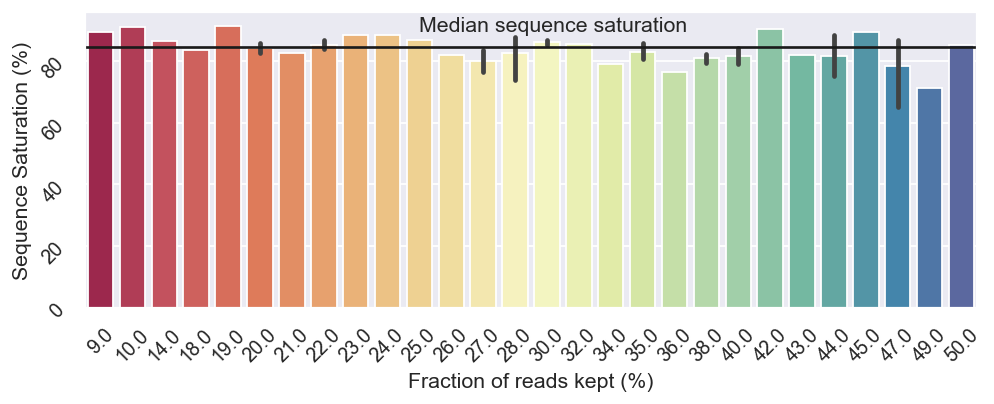

In [8]:
# plot selected libraries and visualize their sequence saturation

sb.set(rc={'figure.figsize':(9,3)})
g=sb.barplot(df_filtered_sorted, x='frac_reads_kept', y="sequence_saturation", palette="Spectral")
plt.axhline(y=df_filtered_sorted['sequence_saturation'].median(), color = 'k', linestyle = '-')
plt.text(10, df_filtered_sorted['sequence_saturation'].median()+5,'Median sequence saturation', rotation=0)
g.tick_params(labelrotation=45)
g.set_xlabel("Fraction of reads kept (%)")
g.set_ylabel("Sequence Saturation (%)")

From the figure above, we observe that most libraries are sufficiently sequenced with a saturation near or above the median `83.75%`. This implies that for most of these samples, subsampling the read depth will not significantly impact the complexity of the gene signatures detected. Suggesting that only a handful of samples were not sufficiently captured. We retain this and a few other outlier library for downstream analysis, ignoring the low post-normalization read depth, since we aim to identify highly and lowly expressed transcripts as well as cluster cells into populations. 

However, we note the outlier libraries (with sequencing saturation `<70%`) for reference.

| ID      | SEQUENCE SATURATION  |  % READS POST-NORMALIZATION  | 
| ----------- | ----------- | ----------- |
| Library D17-8792   | 65.2%       | 90.3%       |
| Library D17-8757   | 68.7%       | 54.9%       |
| Library D17-8765   | 60.4%       | 51.4%       |
| Library D17-8767   | 44.7%       | 100.0%       |
| Library D17-8766   | 65.0%       | 46.9.2%       |

Ultimately, we obtain a total of 70494 unique cells and 36601 genes, which deviate from the 80,660 processed nuclei reported in [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2). In particular, the initial dataset obtained by [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) contained `80,660 cells`, with a median value of `1,496 total read counts over protein-coding genes`, whereas our aggregated data contains `70,494 cells` with `1,446 median read counts per cells including intronic genes`. Below, we note a key sources of variation that could have led to the difference.



|  Source      | Local      | [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2)  |
| ----------- | ----------- | ----------- |
| CellRanger Version   | v7.0.1       |  v2.0.0       | 
| Genome (version)    |  Human (GRCh38) 2020-A (2020-A)     |  hg38 genome (GRCh38.p5 (NCBI:GCA_000001405.20) 2015/09/22   | 
| Post-normalization read depth |  Low (8.7%)     |  Not reported   | 
| Introns Included |  Yes (default in cell ranger v7.0.1)    |  No (not available in cell ranger v2.0.0)  | 

We note that a number of samples have poor `Per base sequence quality`--referring to samples with less than 65% of bases in the RNA reads having a phred quality score of > 30 i,e `there are less than 65% of Q30 bases in the RNA read`. Low Q30 Base percentages could indicate sequencing issue such as sub-optimal loading concentration.

We identify and filter samples with Q30 percentages less than the average Q30 percetange (`73.63%`) in the entire collection. 

Text(0.5, 0, 'Sample ID')

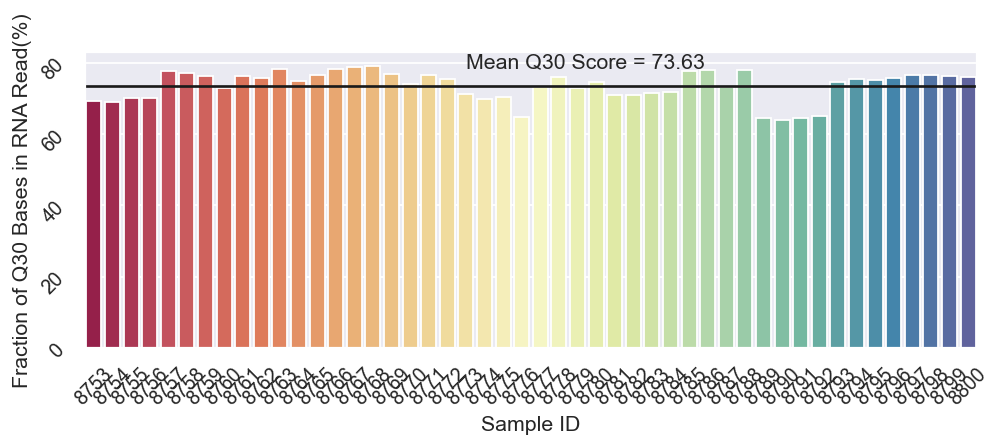

In [9]:
# plot selected libraries and visualize their sequence saturation

sb.set(rc={'figure.figsize':(9,3)})
g=sb.barplot(df_frac_reads_kept, x='sample', y="frac_q30_bases_in_RNA_read", palette="Spectral")
plt.axhline(y=df_frac_reads_kept['frac_q30_bases_in_RNA_read'].mean(), color = 'k', linestyle = '-')
plt.text(20, df_frac_reads_kept['frac_q30_bases_in_RNA_read'].mean()+5,
        f'Mean Q30 Score = {df_frac_reads_kept["frac_q30_bases_in_RNA_read"].mean():.2f}', rotation=0)
g.tick_params(labelrotation=45)
g.set_ylabel("Fraction of Q30 Bases in RNA Read(%)")
g.set_xlabel("Sample ID")

In [10]:
all_samples = list(df_frac_reads_kept['sample'])

# good_samples = list(df_frac_reads_kept[df_frac_reads_kept['frac_q30_bases_in_RNA_read'] >=\
#                                  df_frac_reads_kept['frac_q30_bases_in_RNA_read'].mean()]['sample'])

good_samples = all_samples.copy()

print(f'There are {len(good_samples)} samples that have >73% Q30 bases in RNA')

There are 48 samples that have >73% Q30 bases in RNA


In [11]:
del df_filtered_sorted, df_frac_reads_kept, keys_frac_reads_kept, values_frac_reads_kept, values_sequence_saturation, summary_info, f

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_90735/527058868.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='../data/raw/mathys_pfc_remapped_with_all_samples_using_v7/count/summary.json' mode='r' encoding='UTF-8'>
  del df_filtered_sorted, df_frac_reads_kept, keys_frac_reads_kept, values_frac_reads_kept, values_sequence_saturation, summary_info, f
